In [1]:
%matplotlib inline
import seaborn
import quandl
import pandas as pd
import seaborn as sns
import math
from tsmom_model import *
import numpy as np
from datetime import datetime
import statsmodels.formula.api as sm
token="Us3wFmXGgAj_1cUtHAAR"

import pylab
sns.set(font_scale=3)
pylab.rcParams['figure.figsize'] = (24, 18)

:0: FutureWarning: IPython widgets are experimental and may change in the future.


# Hand cleansed
Hand cleaned to removed duplicates

In [2]:
cleansed=load_amihud_markets_price()

tsmom_model.py:146: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  data=pd.read_csv('Price.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')
tsmom_model.py:148: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  qd=pd.read_csv('liquid_contracts.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')


In [3]:
cleansed.count().count()

123

# Amihud methodology

Amihud (2002) developed the illiquidity measure expressed by:

$$ Amihud = \frac{|r_t|}{\text{volume}_t} $$

where $r_t$ is the return on day $t$ and $Volume_t$ is the dollar volume on day $t$. 

The benefit of taking the daily return is to weight the move by change of price and the volume.


In [4]:
amihud=calculate_amihud_liquidity(cleansed)[:'2016'] 

tsmom_model.py:29: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  data=pd.read_csv('Volume.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='mean')
tsmom_model.py:31: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  v=pd.read_csv('volume_data.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='sum')
tsmom_model.py:33: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(min_periods=100,window=250,center=False).mean()
  volume=pd.rolling_mean(v,250,min_periods=100).resample(rule='d',how='mean')[:'2016']
tsmom_model.py:33: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  volume=pd.rolling_mean(v,250,min_periods=100).resample(rule='d',how='mean')[:'2016']
tsmom_model.py:36: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future versio

Idea:

* Sort portfolios on an annual baisis
* cacluated $\sigma$, $\mu$, skew, max drawdown

* Need to creat panel data and start running regression on that.  

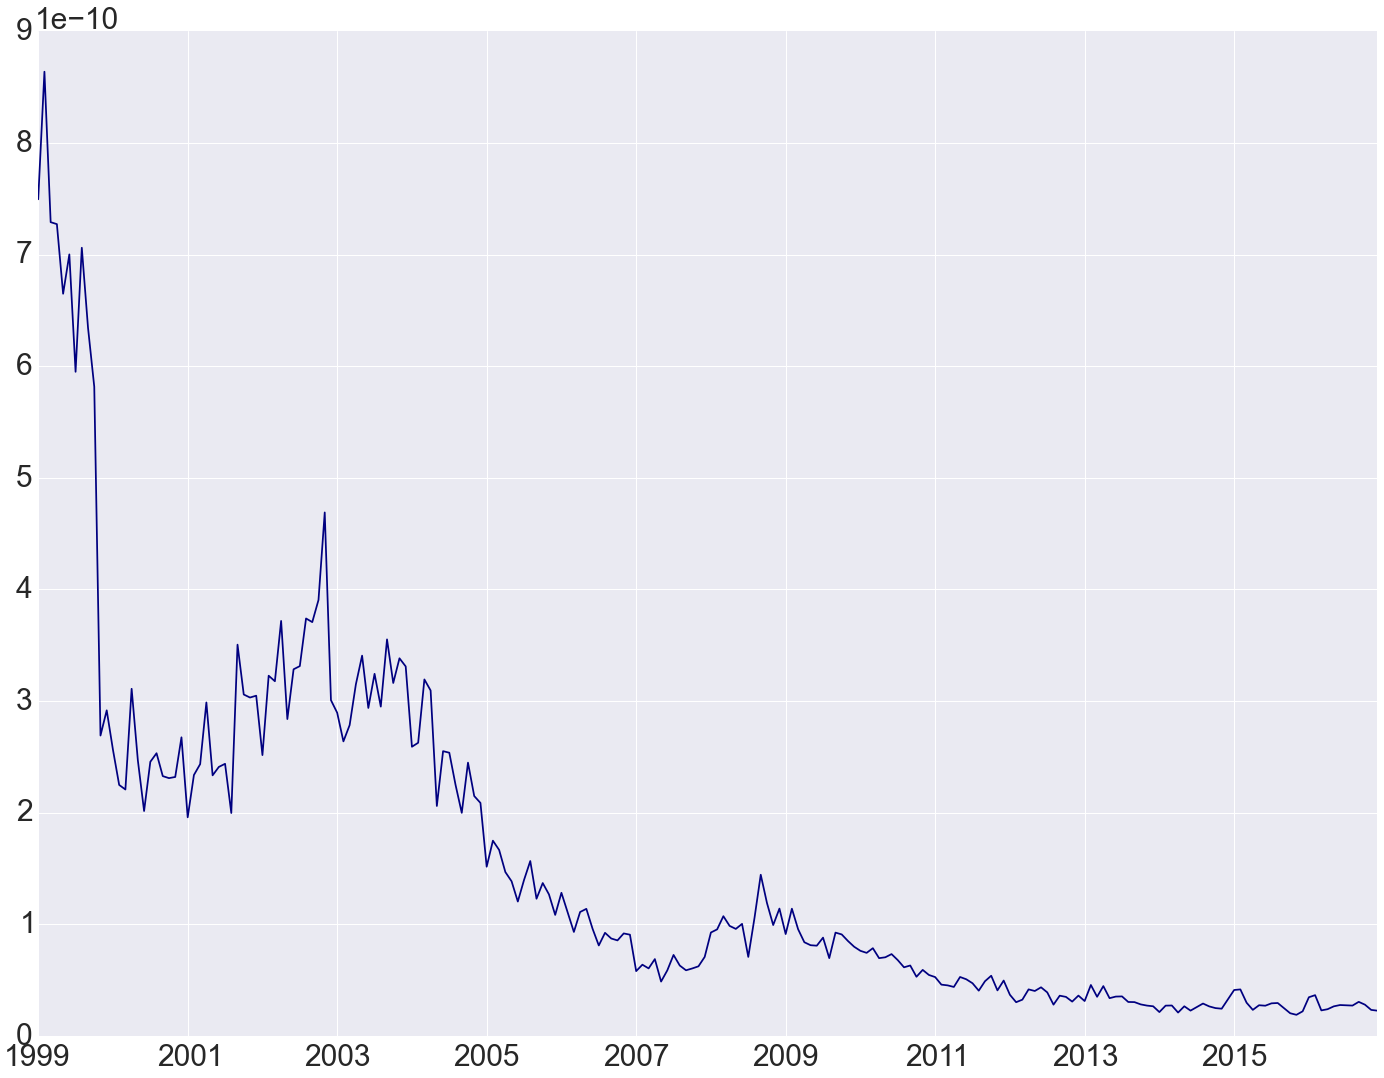

In [5]:
amihud.median(axis=1).dropna().plot(colormap='jet')

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  if __name__ == '__main__':


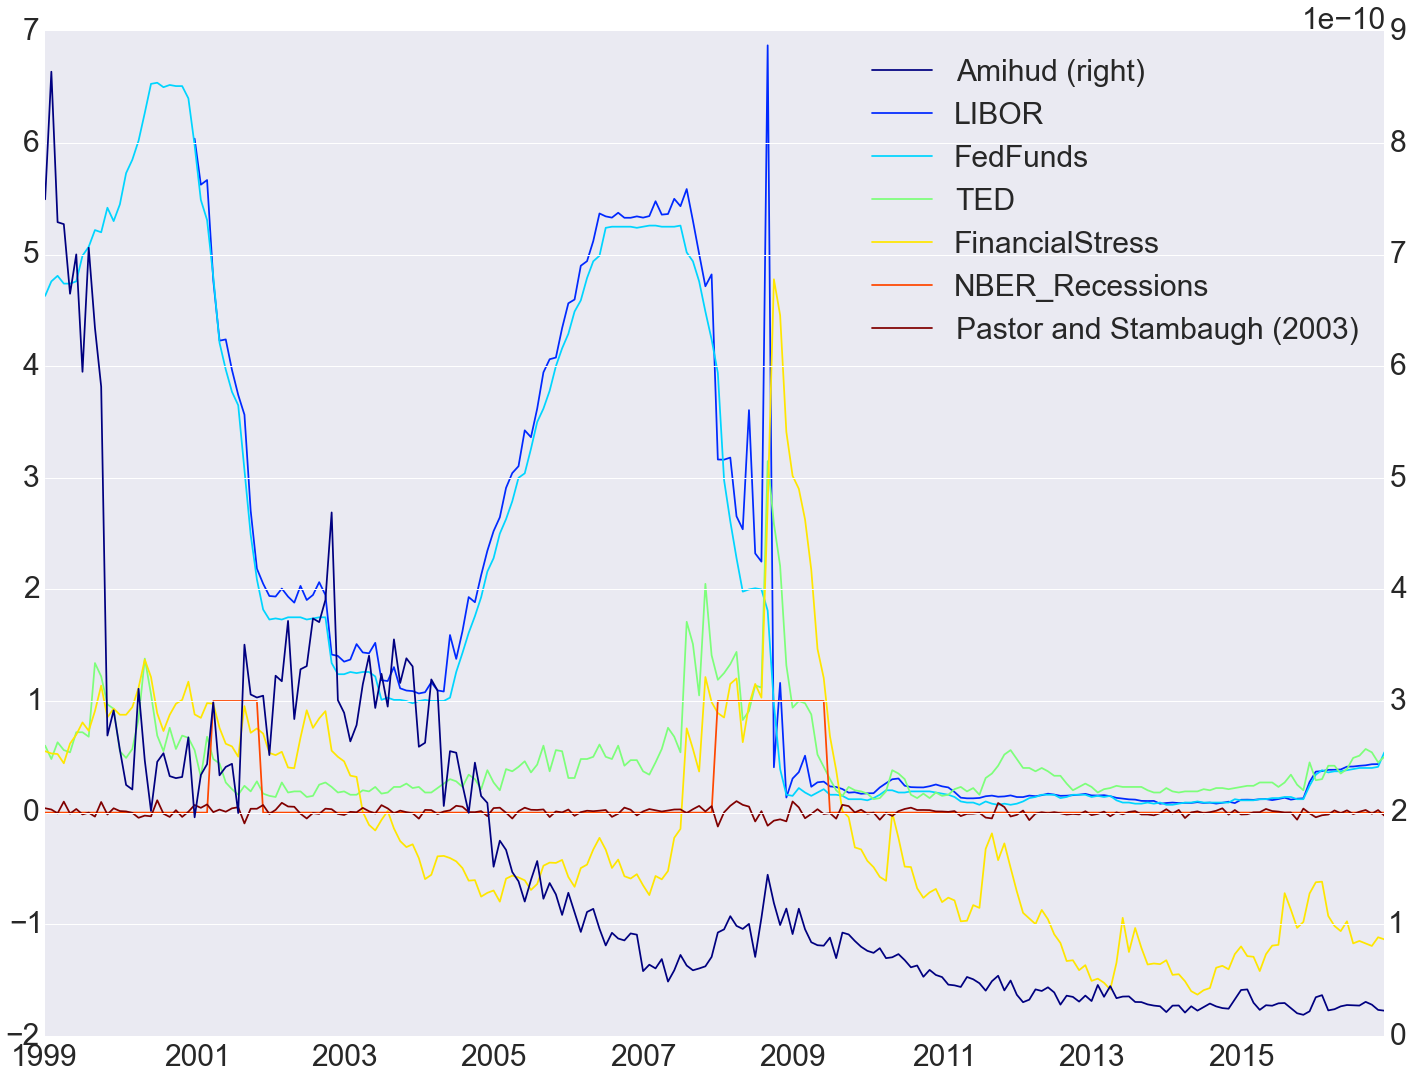

In [52]:
PS=pd.read_csv('PS.csv',parse_dates=[0]).set_index('Month').resample(rule='m',how='last')
df=pd.read_csv('market_liquidity_factors.csv',index_col=0,parse_dates=[0])
df['Pastor and Stambaugh (2003)']=PS['Traded liquidity factor']
df.plot(secondary_y='Amihud',colormap='jet')

# Further undersanding liquidity factor

The further paper is trying to understand why do less liquid markets create this factor.  

The other state variables:
* Amihud (MKTILLIQ)
* LIBOR
* Fed Funds
* TED
* Financial Stress
* NBER Recessions



Trying to understand in the overall median market liquidity and see if some market state varaibles explain it:

$$ MKTILLIQ_i = \alpha_0 + \beta_1 LIBOR_t + \beta_2 TED_t + \beta_3 FinancialStress_t + \beta_4 NBER_Recessions_t + \epsilon_t $$

Where $MKTILLIQ_i$ is the median monthly value of market illiquidity trhough time based on Amihud (2002) illiquidity of my universe of global futures contracts.  $LIBOR_t$ and Treasury over Eurodollar ($TED_t$) spreads is the month end figures.  $FinancialStress_t$ is XXXX. Lastly $NBER_Recessions_t$ is the ressionary periods classified ex-post by NBER.

In [7]:
data=df.dropna()
data['Intercept']=1

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


In [8]:
col=['LIBOR', 'TED', 'FinancialStress','NBER_Recessions']
dd=[]
tt=[]
r2=[]
for i in range(0,4,1):
    reg=['Intercept']
    d=[0]*int(len(col)+1)
    t=[0]*int(len(col)+1)
    reg.append(col[i])
    res=sm.OLS(data.Amihud,data[reg]).fit()
    d[0]=res.params.Intercept
    d[i+1]=res.params[col[i]]
    t[0]=res.tvalues.Intercept
    t[i+1]=res.tvalues[col[i]]
    r2.append(res.rsquared_adj)
    tt.append(t)
    dd.append(d)
d=[0]*int(len(col)+1)
t=[0]*int(len(col)+1)
col.append('Intercept')
res=sm.OLS(data.Amihud,data[col]).fit()
d[0]=res.params.Intercept
t[0]=res.tvalues.Intercept
r2.append(res.rsquared_adj)
i=1
for c in col[:-1]: 
    d[i]=res.params[c] 
    t[i]=res.tvalues[c]
    i=i+1
tt.append(t)
dd.append(d)

Note every coefifient is mutliplied 10e10 given the nature of the model.

In [9]:
pd.DataFrame(r2,columns=['Adjusted R^2']).T

,0,1,2,3,4
Adjusted R^2,0.067145,0.011,0.155922,0.00864,0.538671


In [10]:
ind=col[-1:]+col[:-1]
x=(pd.DataFrame(dd,columns=ind)*1e11).round(2)
x['Adjusted R^2']=pd.Series(r2)
x.T.round(2)

,0,1,2,3,4
Intercept,9.50,13.43,13.10,11.55,20.97
LIBOR,1.52,0.00,0.00,0.00,1.77
TED,0.00,-3.24,0.00,0.00,-19.87
FinancialStress,0.00,0.00,4.03,0.00,9.80
NBER_Recessions,0.00,0.00,0.00,3.70,-6.55
Adjusted R^2,0.07,0.01,0.16,0.01,0.54


In [11]:
pd.DataFrame(tt,columns=ind).round(2).T

,0,1,2,3,4
Intercept,9.43,12.20,17.74,13.81,18.91
LIBOR,3.83,0.00,0.00,0.00,5.82
TED,0.00,-1.76,0.00,0.00,-11.39
FinancialStress,0.00,0.00,6.01,0.00,12.17
NBER_Recessions,0.00,0.00,0.00,1.63,-2.98


In [21]:
ind2=[]
for col in ind:
    ind2.append(col+' Tstat')
tstat=pd.DataFrame(tt,columns=ind2).round(2)

In [27]:
full=tstat.join(x)

In [30]:
print full.T.round(2).to_latex()

\begin{tabular}{lrrrrr}
\toprule
{} &     0 &      1 &      2 &      3 &      4 \\
\midrule
Intercept Tstat       &  9.43 &  12.20 &  17.74 &  13.81 &  18.91 \\
LIBOR Tstat           &  3.83 &   0.00 &   0.00 &   0.00 &   5.82 \\
TED Tstat             &  0.00 &  -1.76 &   0.00 &   0.00 & -11.39 \\
FinancialStress Tstat &  0.00 &   0.00 &   6.01 &   0.00 &  12.17 \\
NBER\_Recessions Tstat &  0.00 &   0.00 &   0.00 &   1.63 &  -2.98 \\
Intercept             &  9.50 &  13.43 &  13.10 &  11.55 &  20.97 \\
LIBOR                 &  1.52 &   0.00 &   0.00 &   0.00 &   1.77 \\
TED                   &  0.00 &  -3.24 &   0.00 &   0.00 & -19.87 \\
FinancialStress       &  0.00 &   0.00 &   4.03 &   0.00 &   9.80 \\
NBER\_Recessions       &  0.00 &   0.00 &   0.00 &   3.70 &  -6.55 \\
Adjusted R\textasciicircum2          &  0.07 &   0.01 &   0.16 &   0.01 &   0.54 \\
\bottomrule
\end{tabular}



#  Table ideas

For one panel I should run correlation matrix on monthly data to see if these are explaining the same thing.  

/Users/mrefermat/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


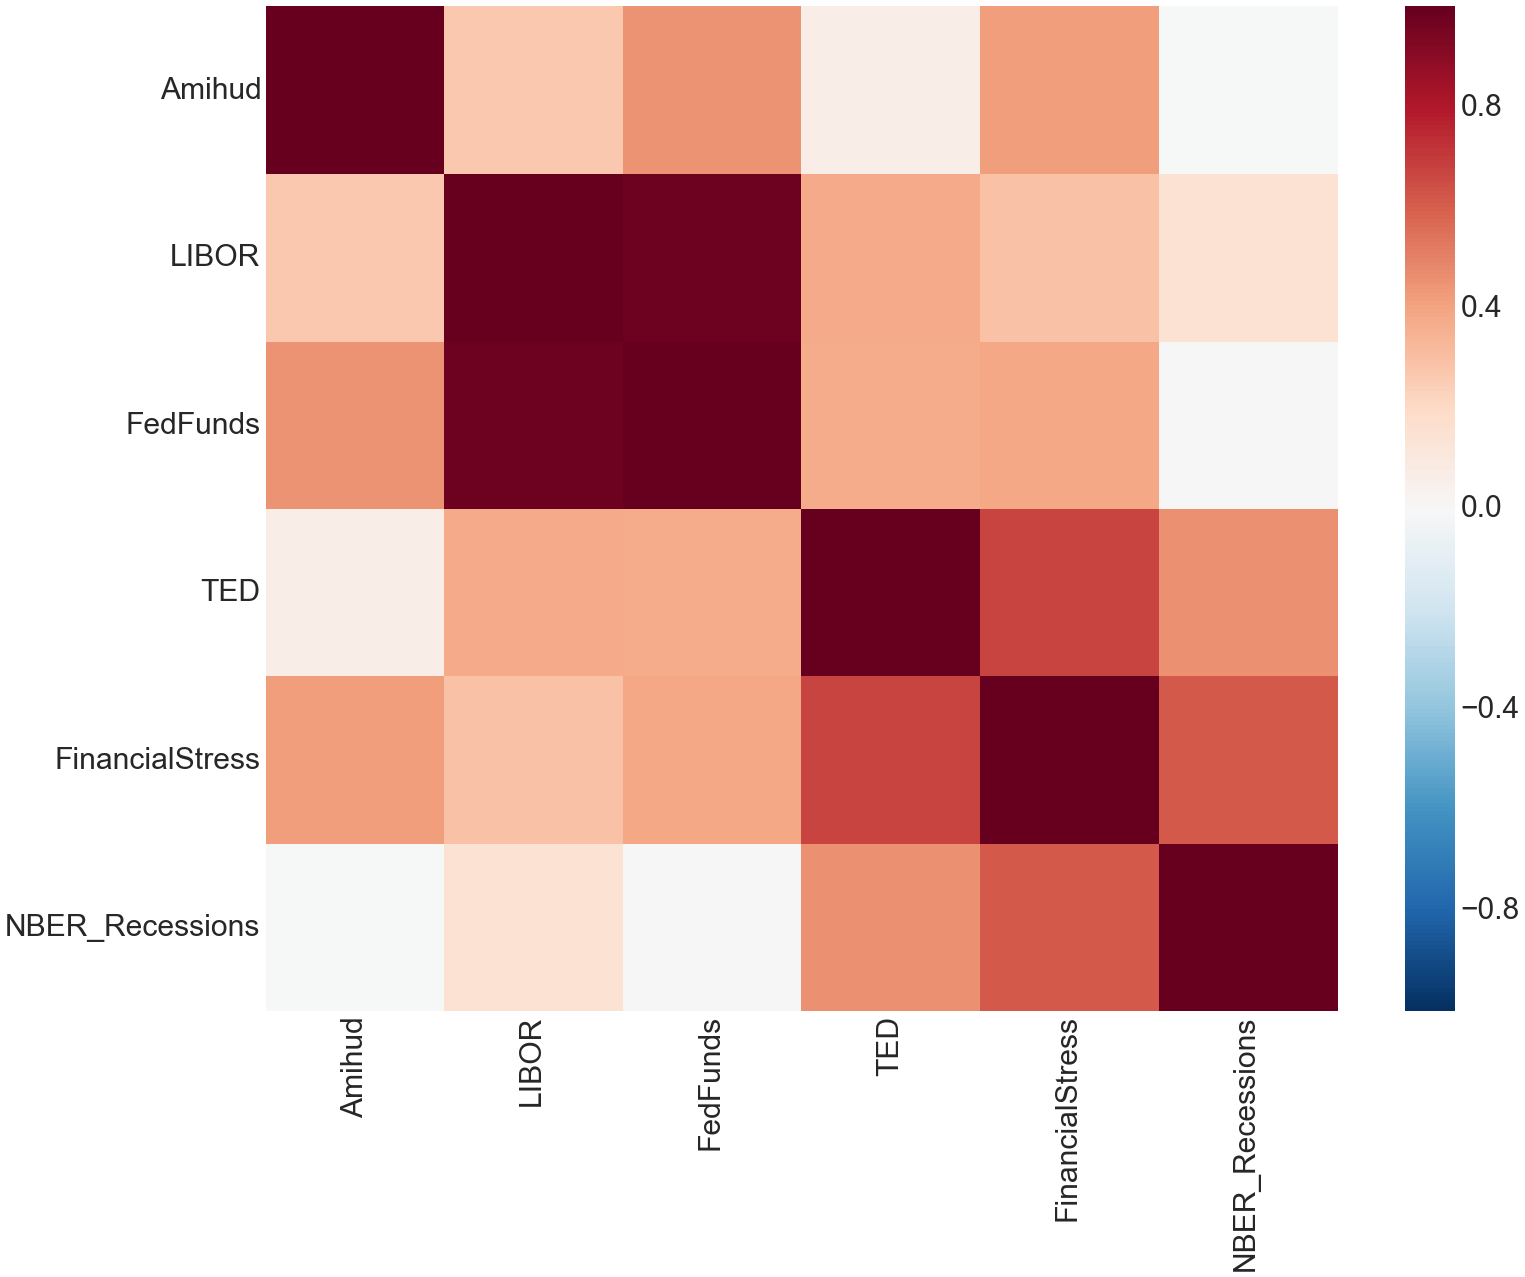

In [13]:
sns.heatmap(df.corr())